# **Housing Sales Prices & Venues in Rome**
--------

## **A. Introduction**

#### **A.1. Description & Disscusion of the Background**

Rome is the eternal city and my favorite city in Europe. I have a lot of fond memories from it when I went back packing through it with my university friends back in 2003. Given that it has been so hard hit by COVID-19 pandemic, I want to pay tribute to it by using it as my project. 

Given that Rome is such a popular tourist destination and has so much history, it has really expensive real estate as well as population density. With the impacts to its economy due to COVID-19, investors can be looking at boroughs of Rome that have a high population and relatively lower real estate prices. In addition, using FourSquare data, I will also look at type of businesses in each borough to be able to recommend the best Rome neighborhood to start a business in and type of business to start based on the real estate prices and population density. 


#### **A.2. Data Description**

To consider the problem we can list the datas as belows

* I got the real estate prices by different neighborhoods of Rome using the statist.com site that contains data as of December, 2019 [https://www.statista.com/statistics/670698/asking-price-for-properties-for-sale-in-rome-by-area-italy/]. 
* I got the .json file for Rome from carto.com site that will help us create the choropleth map of it's neighborhoods [https://maurizioman.carto.com/tables/rome_admin/public/map].
* I used **Forsquare API** to get the most common venues of given Borough of Rome [https://foursquare.com/].


## **B. Methodology**
----

#### **B.1. Creating data table and data pre-processing**

As a database, I created the dataset of Rome boroughs by populating the neighborhood names, real estate prices and geographic coordinates and saved it in my github repository. I then saved it in the pandas dataframe **df** which has the following columns *Borough, Average House Price, Latitude* and *Longitude*.

In [1]:
import pandas as pd 
import numpy as np
import requests

url = 'rome_geo.csv'

df = pd.read_csv(url)

df.head()

,Borough,Avg-HousePrice,Latitude,Longitude
0,CentroStorico,7817,41.8982,12.4773
1,Caracalla,6910,41.8794,12.4931
2,Flaminio,5622,42.1919,12.4725
3,Trastevere,5435,41.8848,12.4704
4,Della Vittoria,5137,41.9182,12.4639


#### **B.2. Visual Map & Clustering in Borough**

We need to import some external libraries for mapping and clustering of the datas and we will work on Forsquare API part, as well. 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


#### We will use folium library to visualize geographic details of Rome and its boroughs.

In [4]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.7.0 --yes 
import folium # map rendering library

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                                4.8.3-py37hc8dfbb8_0 --> 4.8.3-py37hc8dfbb8_1




conda-4.8.3          | 3.1 MB    |            |   0% 
conda-4.8.3          | 3.1 MB    |            |   1% 
conda-4.8.3          | 3.1 MB    | 4          |   4% 
conda-4.8.3          | 3.1 MB    | 7          |   8% 
conda-4.8.3          | 3.1 MB    | #2         |  12% 
conda-4.8.3          | 3.1 MB    | #6         |  17% 
conda-4.8.3          | 3.1 MB    | ##7     

#### I use geopy library to get the latitude and longitude values of Rome

In [5]:
address = 'Rome, IT'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude, longitude))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Rome are 41.8933203, 12.4829321.


#### We can create a map of Rome with boroughs superimposed on top. We use latitude and longitude values to get the visual

In [8]:
map_rome = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_rome)  
    
map_rome

#### Let's utilizing the Foursquare API to explore the boroughs and segment them.

In [9]:
CLIENT_ID = 'VBAQZK33TBEOSYSUNW4SJXETSZLYYLYAHCAHESZJ1WSOZ32Q' # your Foursquare ID
CLIENT_SECRET = 'BQSRXK02ZKWX5WCAXIIPTS42CCHLSHUGKLX1MUOPWUS20322' # your Foursquare Secret
VERSION = '20181102' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VBAQZK33TBEOSYSUNW4SJXETSZLYYLYAHCAHESZJ1WSOZ32Q
CLIENT_SECRET:BQSRXK02ZKWX5WCAXIIPTS42CCHLSHUGKLX1MUOPWUS20322


#### We will get the borough's latitude and longitude values.

In [10]:
rome_data = df

borough_latitude =  rome_data.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = rome_data.loc[0, 'Longitude'] # neighborhood longitude value

borough_name = rome_data.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of CentroStorico are 41.8982, 12.4773.


First, let's create the GET request URL. Name your URL url. I design the limit as 100 venue and the radius 750 meter for each borough

In [11]:
LIMIT = 100
radius = 750
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VBAQZK33TBEOSYSUNW4SJXETSZLYYLYAHCAHESZJ1WSOZ32Q&client_secret=BQSRXK02ZKWX5WCAXIIPTS42CCHLSHUGKLX1MUOPWUS20322&v=20181102&ll=41.8982,12.4773&radius=750&limit=100'

In [12]:
results = requests.get(url).json()

From the Foursquare lab, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pantheon,Monument / Landmark,41.899133,12.476805
1,Pizza e Mozzarella,Pizza Place,41.897598,12.479097
2,Piazza della Rotonda,Plaza,41.899253,12.476779
3,Antica Salumeria,Sandwich Place,41.899209,12.476511
4,Tazza d'Oro,Coffee Shop,41.899435,12.477359


And how many venues were returned by Foursquare?

In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### **B.3. Exploring Boroughs in Rome**

Let's create a function to get all the boroughs in Rome

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we can run the above function on each borough and create a new dataframe called **istanbul_venues**

In [17]:
rome_venues = getNearbyVenues(names=rome_data['Borough'],
                                   latitudes=rome_data['Latitude'],
                                   longitudes=rome_data['Longitude']
                                  )

CentroStorico
Caracalla
Flaminio
Trastevere
Della Vittoria
Trieste
Bologna
CorsoFrancia
Termini
Camilluccia
Balduina
GregorioVII


#### Let's check the size of the resulting dataframe

In [18]:
print(rome_venues.shape)
rome_venues.head()

(488, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CentroStorico,41.8982,12.4773,Pantheon,41.899133,12.476805,Monument / Landmark
1,CentroStorico,41.8982,12.4773,Pizza e Mozzarella,41.897598,12.479097,Pizza Place
2,CentroStorico,41.8982,12.4773,Piazza della Rotonda,41.899253,12.476779,Plaza
3,CentroStorico,41.8982,12.4773,Antica Salumeria,41.899209,12.476511,Sandwich Place
4,CentroStorico,41.8982,12.4773,Tazza d'Oro,41.899435,12.477359,Coffee Shop


#### Let's check how many venues were returned for each borough and sort them in count

In [19]:
summary = rome_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Borough,Count
0,Camilluccia,1
1,Caracalla,11
2,Balduina,22
3,GregorioVII,25
4,Della Vittoria,35


#### We can create a bar chart and analyze the big picture of it

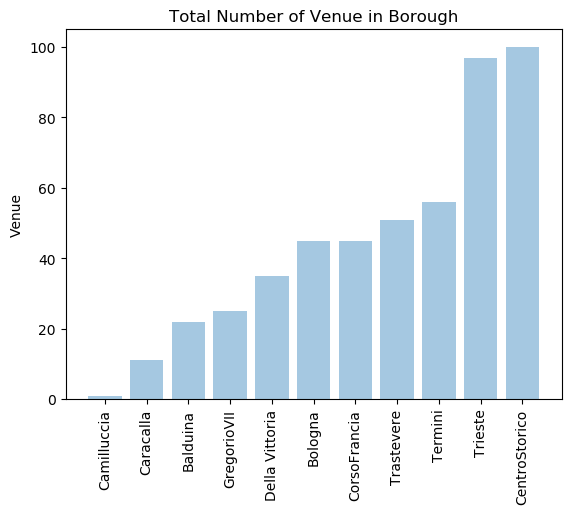

In [21]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

The above bar chart shows us that Centro Storico and Trieste have close to 100 venues, followed by Tremini, Trastavere, Corso Francia, Della Vittoria and Bologna that have venues in 40-60 range. Remaining boroughs are less venue rich like Georgio VII, Balduina, Caracalla and Camillucia. Camillucia specially seems really low in venue and therefore likely is not very population or tourist dense. 

Let's find out how many unique categories can be curated from all the returned venues

In [22]:
print('There are {} uniques categories.'.format(len(rome_venues['Venue Category'].unique())))

There are 101 uniques categories.


#### **B.4. Analyzing Each Borough**

We will anayze each borough with venues informations

In [25]:
# one hot encoding
rome_onehot = pd.get_dummies(rome_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rome_onehot['Borough'] = rome_venues['Borough'] 

# move neighborhood column to the first column
list_column = rome_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
rome_onehot = rome_onehot[list_column]

rome_onehot.head(20)

,Borough,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Cafeteria,Café,Campanian Restaurant,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Eastern European Restaurant,Fast Food Restaurant,Festival,Flea Market,Flower Shop,Food Court,Fountain,Garden,Gastropub,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Historic Site,History Museum,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lounge,Market,Men's Store,Middle Eastern Restaurant,Monument / Landmark,Multiplex,Museum,Nightclub,Noodle House,Opera House,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Piadineria,Piedmontese Restaurant,Pizza Place,Plaza,Pool,Pub,Restaurant,Roman Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Smoke Shop,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Track Stadium,Train Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop
0,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,CentroStorico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [26]:
rome_grouped = rome_onehot.groupby('Borough').mean().reset_index()
rome_grouped.head()

,Borough,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Cafeteria,Café,Campanian Restaurant,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Eastern European Restaurant,Fast Food Restaurant,Festival,Flea Market,Flower Shop,Food Court,Fountain,Garden,Gastropub,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Historic Site,History Museum,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lounge,Market,Men's Store,Middle Eastern Restaurant,Monument / Landmark,Multiplex,Museum,Nightclub,Noodle House,Opera House,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Piadineria,Piedmontese Restaurant,Pizza Place,Plaza,Pool,Pub,Restaurant,Roman Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Smoke Shop,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Track Stadium,Train Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop
0,Balduina,0.00,0.00,0.00,0.045455,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.045455,0.00,0.00,0.0,0.045455,0.045455,0.0,0.0,0.045455,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.045455,0.000000,0.0,0.00,0.272727,0.045455,0.0,0.045455,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.045455,0.045455,0.045455,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.0,0.045455,0.000000,0.0,0.045455,0.0,0.0,0.00,0.000000,0.045455,0.000000,0.000000,0.0,0.0,0.00,0.0
1,Bologna,0.00,0.00,0.00,0.022222,0.0,0.044444,0.088889,0.022222,0.0,0.044444,0.00,0.00,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.044444,0.0,0.0,0.000000,0.00,0.00,0.0,0.022222,0.000000,0.0,0.0,0.000000,0.022222,0.0,0.0,0.0,0.000000,0.0,0.022222,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.044444,0.022222,0.000000,0.0,0.000000,0.0,0.0,0.044444,0.022222,0.0,0.00,0.155556,0.022222,0.0,0.000000,0.0,0.0,0.0,0.022222,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.066667,0.000000,0.000000,0.022222,0.066667,0.0,0.00,0.022222,0.00,0.0,0.000000,0.022222,0.0,0.044444,0.0,0.0,0.00,0.000000,0.000000,0.044444,0.022222,0.0,0.0,0.00,0.0
2,Camilluccia,0.00,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0
3,Caracalla,0.00,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0,0.00,0.090909,0.0,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.090909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,0.0,0.090909,0.0,0.181818,0.0,0.0,0.090909,0.0,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.090909,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0
4,CentroStorico,0.01,0.01,0.01,0.000000,0.0,0.010000,0.000000,0.000000,0.0,0.000000,0.

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.


In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = rome_grouped['Borough']

for ind in np.arange(rome_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rome_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balduina,Italian Restaurant,Hotel,Spa,Coffee Shop,Chinese Restaurant,Department Store,Pizza Place,Plaza,Pool,Lounge
1,Bologna,Italian Restaurant,Bar,Pizza Place,Restaurant,Beer Bar,Bakery,Ice Cream Shop,Supermarket,Café,Trattoria/Osteria
2,Camilluccia,Nightclub,Wine Shop,Flea Market,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Eastern European Restaurant
3,Caracalla,Park,Performing Arts Venue,Plaza,Garden,Italian Restaurant,Festival,Nightclub,Opera House,Historic Site,Track Stadium
4,CentroStorico,Italian Restaurant,Plaza,Ice Cream Shop,Hotel,Sandwich Place,Fountain,Restaurant,Monument / Landmark,Pizza Place,Church


#### **B.5. Cluster of Boroughs**

K-Means algorithm is one of the most common cluster method of **unsupervised learning**. I will use K-Means algorithm for my study in this project.

First, I will run K-Means to cluster the boroughs into 2 clusters because when I analyze the K-Means with elbow method it ensured me the 2 degree for optimum k of the K-Means

In [67]:
# set number of clusters
kclusters = 2

#rome_grouped_clustering = rome_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_[0:11]
labels

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

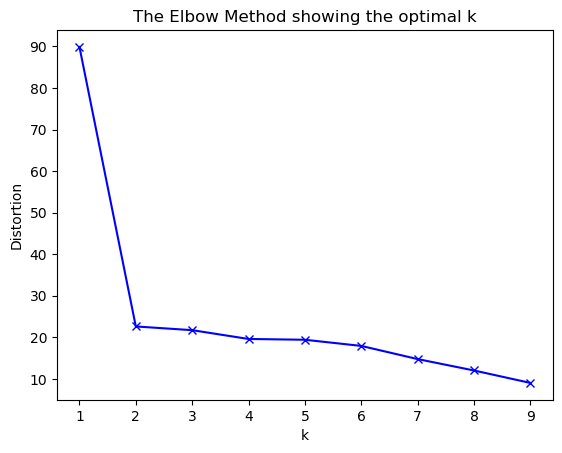

In [68]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(rome_grouped_clustering)
    
    distortions.append(sum(np.min(cdist(rome_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / rome_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [73]:
rome_merged = rome_data

# add clustering labels
#rome_merged['Cluster Labels'] = kmeans.labels_
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge rome_grouped with rome_data to add latitude/longitude for each neighborhood
rome_merged = rome_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

rome_merged.head(20) # check the last columns!

,Borough,Avg-HousePrice,Latitude,Longitude,Cluster Labels,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CentroStorico,7817,41.898200,12.477300,1.0,1.0,Italian Restaurant,Plaza,Ice Cream Shop,Hotel,Sandwich Place,Fountain,Restaurant,Monument / Landmark,Pizza Place,Church
1,Caracalla,6910,41.879400,12.493100,1.0,1.0,Park,Performing Arts Venue,Plaza,Garden,Italian Restaurant,Festival,Nightclub,Opera House,Historic Site,Track Stadium
2,Flaminio,5622,42.191900,12.472500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trastevere,5435,41.884800,12.470400,1.0,1.0,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza,Hotel Bar,Indie Movie Theater,Coffee Shop
4,Della Vittoria,5137,41.918200,12.463900,1.0,1.0,Italian Restaurant,Café,Pizza Place,Plaza,Breakfast Spot,Brazilian Restaurant,Hotel,Food Court,Ice Cream Shop,Convenience Store
5,Trieste,4884,45.649500,13.776800,1.0,1.0,Café,Italian Restaurant,Plaza,Hotel,Pizza Place,Bar,Clothing Store,Bookstore,Cocktail Bar,Diner
6,Bologna,4531,44.498955,11.327500,1.0,1.0,Italian Restaurant,Bar,Pizza Place,Restaurant,Beer Bar,Bakery,Ice Cream Shop,Supermarket,Café,Trattoria/Osteria
7,CorsoFrancia,4289,45.076734,7.667100,1.0,1.0,Italian Restaurant,Café,Pizza Place,Plaza,Sushi Restaurant,Piedmontese Restaurant,Hotel,Piadineria,Cafeteria,Campanian Restaurant
8,Termini,4107,41.901100,12.501200,1.0,1.0,Hotel,Italian Restaurant,Plaza,Ice Cream Shop,History Museum,Roman Restaurant,Pizza Place,Church,Trattoria/Osteria,Department Store
9,Camilluccia,4099,43.968130,12.662350,0.0,0.0,Nightclub,Wine Shop,Flea Market,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Eastern European Restaurant


#### We can also estimate the number of **1st Most Common Venue** in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [74]:
count_venue = rome_merged
count_venue = count_venue.drop(['Borough','Avg-HousePrice', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Café,Hotel,Italian Restaurant,Nightclub,Park,Pizza Place
0,0,0,0,1,0,0
1,1,1,6,0,1,1


Text(0, 0.5, 'Clusters')

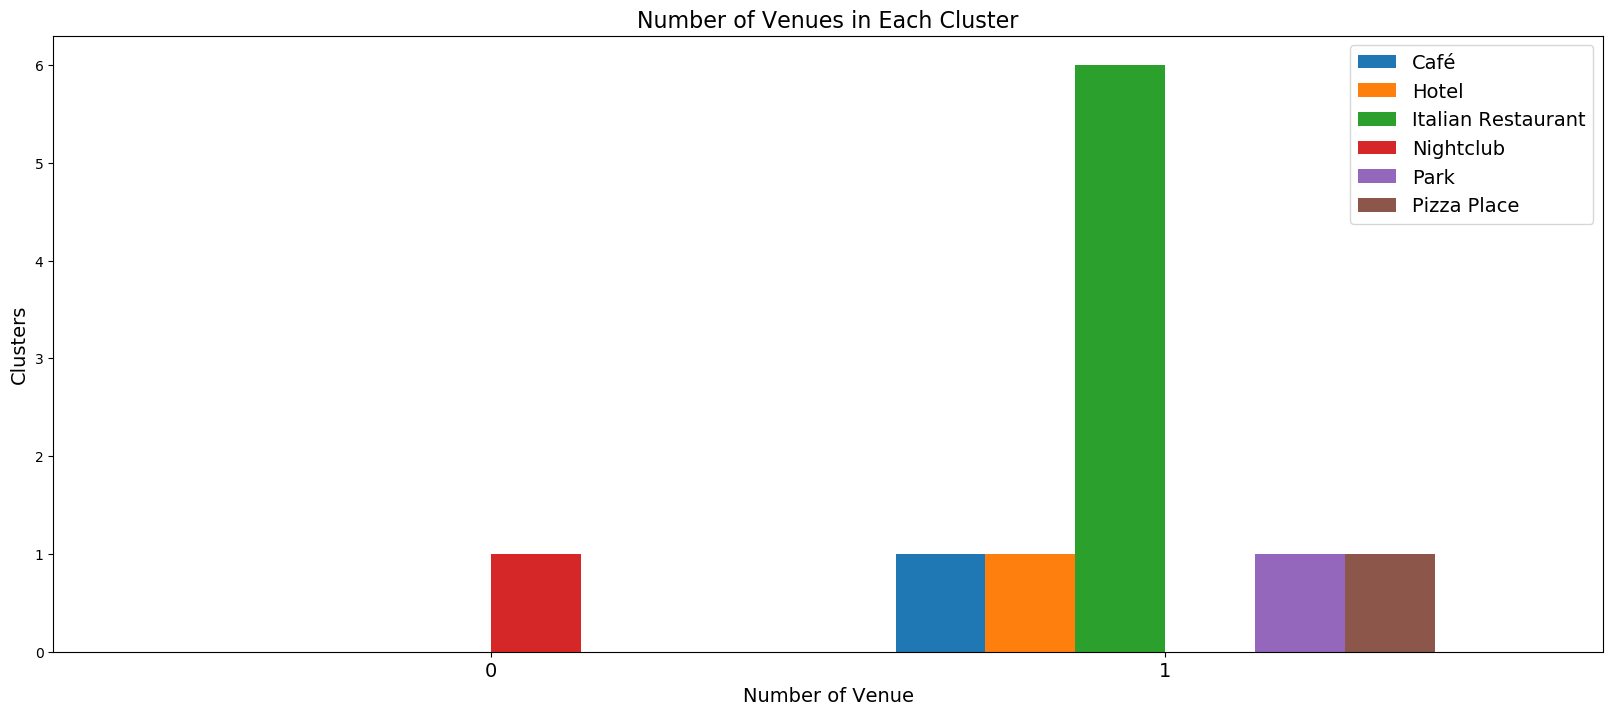

In [75]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

When we examine above graph we can label each cluster as follows:
* Cluster 0 : "Night Club"
* Cluster 1 : "Multiple Social Venues"

We can now assign those new labels to existing label of clusters:

In [76]:
Cluster_labels = {'Clusters': [0,1], 'Labels': ["Night Club","Multiple Social Venues"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Night Club
1,1,Multiple Social Venues


Let's analyze the housing sales prices for per square meter in specific range. Thus we can create new labels which involve pricing features, as well.

In [88]:
data_process = df.sort_values('Avg-HousePrice').reset_index(drop=True)
data_process = data_process.drop(['Latitude', 'Longitude'], axis=1)
data_process.head(12)

,Borough,Avg-HousePrice
0,GregorioVII,3972
1,Balduina,4000
2,Camilluccia,4099
3,Termini,4107
4,CorsoFrancia,4289
5,Bologna,4531
6,Trieste,4884
7,Della Vittoria,5137
8,Trastevere,5435
9,Flaminio,5622


We can examine that what is the frequency of housing sales prices in different ranges. Thus, histogram can help to visualization

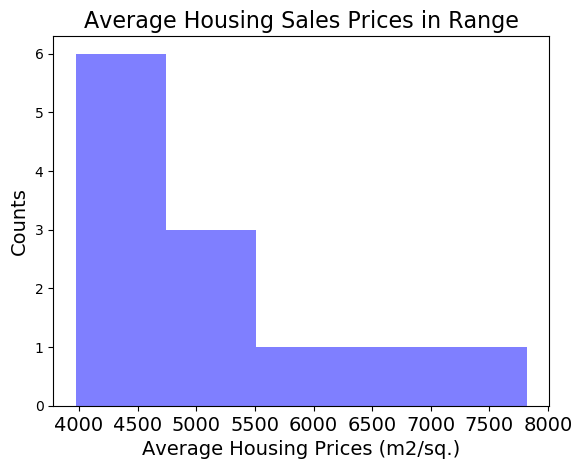

In [78]:
num_bins = 5
n, bins, patches = plt.hist(data_process['Avg-HousePrice'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Housing Sales Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

#### As it seems in above histogram, we can define the ranges as below:

* 4000 AHP : "Low Level HSP"
* 4000-6000 AHP : "Mid Level HSP"
* 6000-8000 AHP : "High Level HSP"

In this case, we can create **"Level_labels"** with those levels.

In [87]:
level = []
for i in range(0,len(data_process)):
    if (data_process['Avg-HousePrice'][i] < 4000):
        level.append("Low Level HSP")
    elif (data_process['Avg-HousePrice'][i] >= 4000 and data_process['Avg-HousePrice'][i] < 6000):
        level.append("Mid Level HSP")
    elif (data_process['Avg-HousePrice'][i] >= 6000 and data_process['Avg-HousePrice'][i] < 8000):
        level.append("High Level HSP")
    
data_process['Level_labels'] = level
data_process.head(12)

,Borough,Avg-HousePrice,Level_labels
0,GregorioVII,3972,Low Level HSP
1,Balduina,4000,Mid Level HSP
2,Camilluccia,4099,Mid Level HSP
3,Termini,4107,Mid Level HSP
4,CorsoFrancia,4289,Mid Level HSP
5,Bologna,4531,Mid Level HSP
6,Trieste,4884,Mid Level HSP
7,Della Vittoria,5137,Mid Level HSP
8,Trastevere,5435,Mid Level HSP
9,Flaminio,5622,Mid Level HSP


One of my aim was also show the number of top 3 venues information for each borough on the map. Thus, I grouped each borough by the number of top 3 venues and I combined those informations in **Join** column.

In [86]:
top3 = rome_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Join'].apply(", ".join).reset_index()

top3.head(12)

,Borough,Join
0,Balduina,"6 Italian Restaurant, 2 Hotel, 1 Asian Restaurant"
1,Bologna,"7 Italian Restaurant, 4 Bar, 3 Pizza Place"
2,Camilluccia,1 Nightclub
3,Caracalla,"2 Park, 1 Festival, 1 Garden"
4,CentroStorico,"16 Italian Restaurant, 14 Plaza, 9 Ice Cream Shop"
5,CorsoFrancia,"6 Italian Restaurant, 4 Café, 4 Pizza Place"
6,Della Vittoria,"7 Italian Restaurant, 4 Café, 2 Breakfast Spot"
7,GregorioVII,"3 Café, 3 Hotel, 3 Pizza Place"
8,Termini,"16 Hotel, 12 Italian Restaurant, 4 Plaza"
9,Trastevere,"12 Italian Restaurant, 5 Pizza Place, 4 Café"


## **C. Results**

### **C.1. Main table with results**

#### Let's merge those new variables with related cluster informations in our main **istanbul_merged** table.

In [85]:
import numpy as np

result = pd.merge(rome_merged, 
                    top3[['Borough', 'Join']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Borough', 'Level_labels']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(12)

,Borough,Avg-HousePrice,Latitude,Longitude,Cluster Labels,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels,Level_labels
0,CentroStorico,7817,41.898200,12.477300,1.0,1.0,Italian Restaurant,Plaza,Ice Cream Shop,Hotel,Sandwich Place,Fountain,Restaurant,Monument / Landmark,Pizza Place,Church,"16 Italian Restaurant, 14 Plaza, 9 Ice Cream Shop",Multiple Social Venues,High Level HSP
1,Caracalla,6910,41.879400,12.493100,1.0,1.0,Park,Performing Arts Venue,Plaza,Garden,Italian Restaurant,Festival,Nightclub,Opera House,Historic Site,Track Stadium,"2 Park, 1 Festival, 1 Garden",Multiple Social Venues,High Level HSP
2,Flaminio,5622,42.191900,12.472500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Level HSP
3,Trastevere,5435,41.884800,12.470400,1.0,1.0,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza,Hotel Bar,Indie Movie Theater,Coffee Shop,"12 Italian Restaurant, 5 Pizza Place, 4 Café",Multiple Social Venues,Mid Level HSP
4,Della Vittoria,5137,41.918200,12.463900,1.0,1.0,Italian Restaurant,Café,Pizza Place,Plaza,Breakfast Spot,Brazilian Restaurant,Hotel,Food Court,Ice Cream Shop,Convenience Store,"7 Italian Restaurant, 4 Café, 2 Breakfast Spot",Multiple Social Venues,Mid Level HSP
5,Trieste,4884,45.649500,13.776800,1.0,1.0,Café,Italian Restaurant,Plaza,Hotel,Pizza Place,Bar,Clothing Store,Bookstore,Cocktail Bar,Diner,"11 Café, 8 Italian Restaurant, 8 Plaza",Multiple Social Venues,Mid Level HSP
6,Bologna,4531,44.498955,11.327500,1.0,1.0,Italian Restaurant,Bar,Pizza Place,Restaurant,Beer Bar,Bakery,Ice Cream Shop,Supermarket,Café,Trattoria/Osteria,"7 Italian Restaurant, 4 Bar, 3 Pizza Place",Multiple Social Venues,Mid Level HSP
7,CorsoFrancia,4289,45.076734,7.667100,1.0,1.0,Italian Restaurant,Café,Pizza Place,Plaza,Sushi Restaurant,Piedmontese Restaurant,Hotel,Piadineria,Cafeteria,Campanian Restaurant,"6 Italian Restaurant, 4 Café, 4 Pizza Place",Multiple Social Venues,Mid Level HSP
8,Termini,4107,41.901100,12.501200,1.0,1.0,Hotel,Italian Restaurant,Plaza,Ice Cream Shop,History Museum,Roman Restaurant,Pizza Place,Church,Trattoria/Osteria,Department Store,"16 Hotel, 12 Italian Restaurant, 4 Plaza",Multiple Social Venues,Mid Level HSP
9,Camilluccia,4099,43.968130,12.662350,0.0,0.0,Nightclub,Wine Shop,Flea Market,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Eastern European Restaurant,1 Nightclub,Night Club,Mid Level HSP


#### You can now see **Join**, **Labels** and **Level_labels** columns as the last three ones in above table.

### **C.2. Map of Cluster Results**

Finally, let's visualize the resulting clusters

In [100]:
import math
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    if (math.isnan(cluster_number)== False):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color= rainbow[int(cluster_number-1)],
            popup=label,
            fill_color = rainbow[int(cluster_number-1)],
            fill_opacity=1).add_to(map_clusters)
       
map_clusters

### **C.3. Map of Housing Sales Prices**

In summary section, one of my aim was also visualize the Average Housing Sale Prices for per square meter with choropleth style map. To make it work, I downloaded a json file for Rome from Carto site [https://maurizioman.carto.com/tables/rome_admin/public/map]. 


In [105]:
rome_geo = 'rome_admin.geojson'

#Rome coordinates
latitude = 41.9028
longitude = 12.4964

# display Rome
rome_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In final section, I created choropleth map which also has the below informations for each borough:
* Borough name,
* Cluster name,
* Housing Sales Price (HSP) Levels,
* Top 3 number of venue

In [106]:
rome_map.choropleth(
    geo_data=rome_geo,
    data=rome_data,
    columns=['Borough','Avg-HousePrice'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in Rome',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    
    if (math.isnan(cluster_number)== False):
    
        folium.CircleMarker(
            [lat, lon],
            radius=7,
            popup=label,
            color= rainbow[int(cluster_number-1)],
            fill=True,
            fill_color= rainbow[int(cluster_number-1)],
            fill_opacity=1).add_to(rome_map)
   
#display map
rome_map

## **D. Summary of Analysis**

As a summary of my analysis, I used a data set containing the names of different neighborhoods for Rome as well as the average house price and longitude and latitude coordinates of those neighborhoods. I further augmented this dataset by using Foursquare API, to bring in details of the most common venues in each neighborhood. 

I used K-mean algorithm and elbow method that recommended segmenting the data into 2 clusters overall where Camillucia neighborhood ended up in Cluster 0 and remaining neighborhoods ended up in Cluster 1. When I analyzed the most common venues in each neighborhood, it also became quite apparent that while in Cluster 1, there are a number of italian restaurants and other socialization venues like cafes and hotels, Cluster 0 mainly had night clubs and wine bars.

When I further visualized the data by overlaying the real estate prices, Cluster 0 looks even more attractive from a business investment perspective as the real estate prices fall in the mid level sales price range. 

## **F. Conclusion**

Based on the above analysis, I recommend Cluster 0 (Camillucia neighborhood) as a good option for business investment and more specifically opening up an Italian restaurant or Pizza joint as there is minimum to no competition for food locations for night club goers and the real estate price is in the mid-range. 

## **G. References:**

* [1] [Rome - Statista](https://www.statista.com/statistics/670698/asking-price-for-properties-for-sale-in-rome-by-area-italy/)
* [2] [Carto Rome JSON file](https://maurizioman.carto.com/tables/rome_admin/public/map)
* [3] [Forsquare API](https://developer.foursquare.com/)
* [4] [Google Map](https://www.google.com/maps/)
